# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [37]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [38]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [39]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period='1d', interval='15m')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-06-03 09:00:00+09:00,37598.308594,37629.078125,37509.789062,37524.011719,0,0.0,0.0
2025-06-03 09:15:00+09:00,37527.148438,37584.890625,37509.808594,37553.328125,0,0.0,0.0
2025-06-03 09:30:00+09:00,37553.480469,37647.968750,37553.480469,37623.351562,0,0.0,0.0
2025-06-03 09:45:00+09:00,37617.730469,37633.019531,37586.859375,37614.089844,0,0.0,0.0
2025-06-03 10:00:00+09:00,37612.308594,37637.011719,37590.281250,37636.179688,0,0.0,0.0
2025-06-03 10:15:00+09:00,37634.648438,37659.511719,37614.910156,37650.078125,0,0.0,0.0
2025-06-03 10:30:00+09:00,37650.328125,37713.468750,37650.328125,37709.261719,0,0.0,0.0
2025-06-03 10:45:00+09:00,37708.761719,37729.449219,37693.109375,37710.179688,0,0.0,0.0
2025-06-03 11:00:00+09:00,37708.031250,37711.800781,37615.421875,37615.421875,0,0.0,0.0


## 前日終値の取得

In [40]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(period='1d', interval='1d', start=str(dt_prev.date()))
n = len(df_last)
lastclose = df_last[n-2:n-1]['Close'].iloc[0]
# 確認のため出力
df_last[n-2:n-1]['Close']

Date
2025-06-02 00:00:00+09:00    37470.671875
Name: Close, dtype: float64

## ローソク足チャート（小さいサイズ）

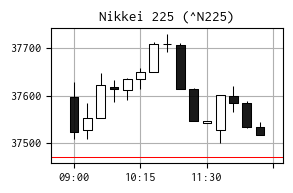

In [41]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type='candle',
    style='default',
    datetime_format='%H:%M',
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")
    
plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()